In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy


sc.set_figure_params(figsize=(4, 4))

In [2]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
#     ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
#                        dpi=300, orientation='landscape', format= 'pdf', optimize=True)

# MALE

### Read in dataset

In [3]:
path_to_gonads = '/nfs/team292/lg18/with_valentina/gonadsV2_revision/'

In [4]:
adata = sc.read(path_to_gonads + 'FCA-gonads_rawcounts.h5ad')

In [5]:
# Add old lineage subname
metaF = pd.read_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
metaF = metaF.set_index('Unnamed: 0')
metaF.head()

cell_annot = metaF['lineage'].to_dict()
adata.obs['lineage_v2'] = adata.obs_names.map(cell_annot).astype('category')


/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (29,30) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
adata = adata[[i in 'male' for i in adata.obs.sex]]
adata.X.shape

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


(152593, 28820)

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

Trying to set attribute `.var` of view, copying.


### Remove cc genes

In [8]:
# ccgs defined in M1
adata = adata[:,[i not in adata.uns['ccgs'] for i in adata.var_names]]
print('Total number of genes after ccg filter: {:d}'.format(adata.n_vars))

Total number of genes after ccg filter: 26615


### Identify HVGs

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    subset=False,
    flavor="seurat_v3",
    batch_key="donor"
)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
Trying to set attribute `.uns` of view, copying.


In [10]:
# subset object for latter
bdata = adata[:, adata.var['highly_variable']]
bdata.layers["counts"] = bdata.X.copy() # preserve counts

## Normalize

In [11]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

### Load latent space scVI

In [12]:
X_scVI = pd.read_csv(path_to_gonads+'/FCA-gonads_XscVI_latent_male.csv', index_col=0)
adata.obsm["X_scVI"] = X_scVI.to_numpy()

### Clustering

In [13]:
# use scVI latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.4)

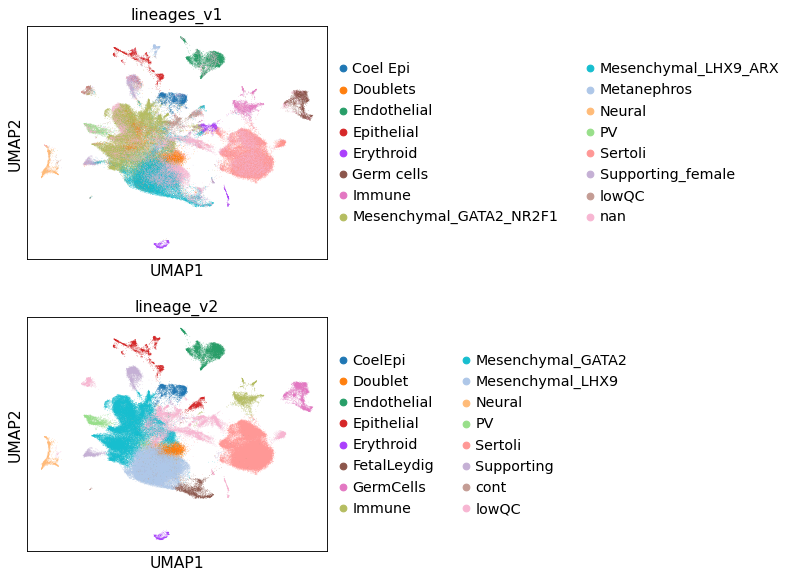

In [14]:
sc.pl.umap(
    adata,
    color=['lineages_v1',  "lineage_v2"], 
    frameon=True, ncols = 1, wspace = 0.3
)

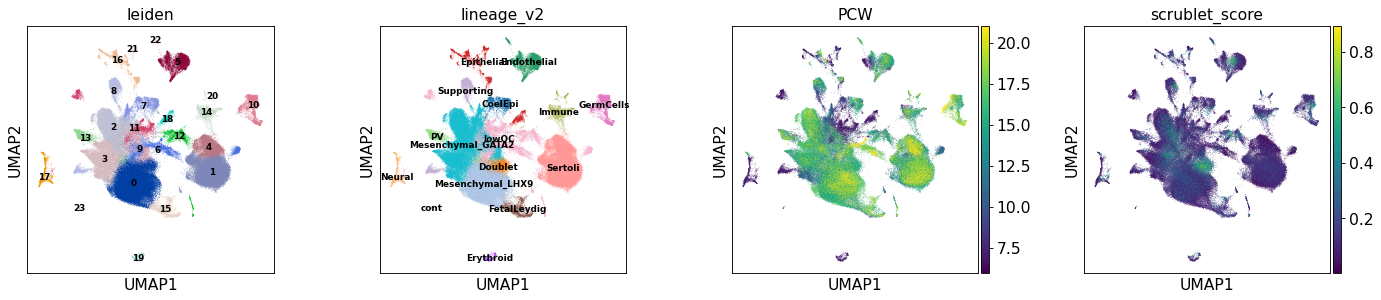

In [15]:
sc.tl.leiden(adata, resolution=0.7)
sc.pl.umap(
    adata,
    color=['leiden', 'lineage_v2', 'PCW', 'scrublet_score'], legend_loc='on data',legend_fontsize=8,
    frameon=True,  wspace = 0.3
)


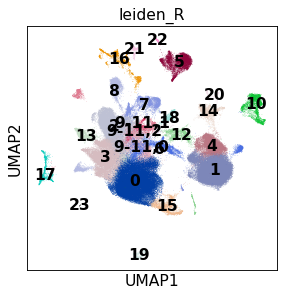

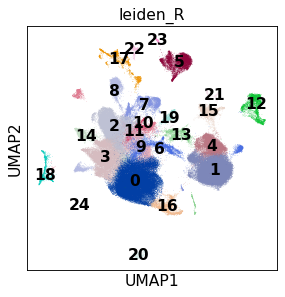

In [16]:
# split lowQC cluster
sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['9', '11']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

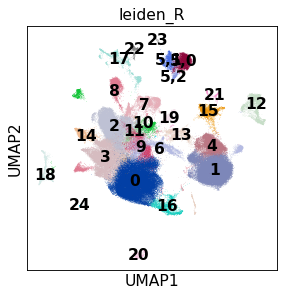

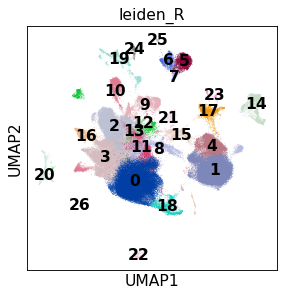

In [17]:
# split lowQC cluster
sc.tl.leiden(adata, resolution=0.1, restrict_to=('leiden', ['5']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

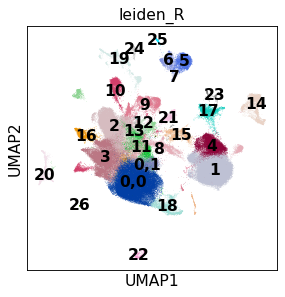

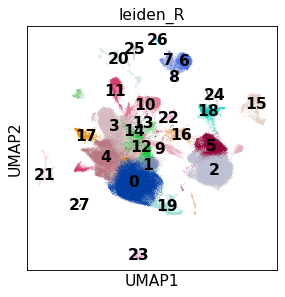

In [18]:
# isolate doublet
sc.tl.leiden(adata, resolution=0.3, restrict_to=('leiden', ['0']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

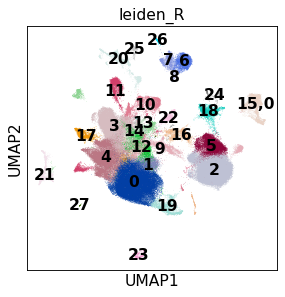

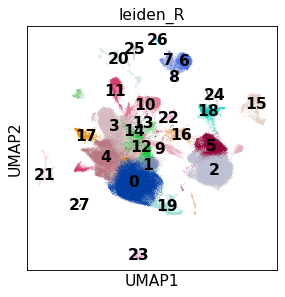

In [19]:
# isolate lowQC from coel epi
sc.tl.leiden(adata, resolution=0.05, restrict_to=('leiden', ['15']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden'] = adata.obs['leiden_R']

## Annotate clusters

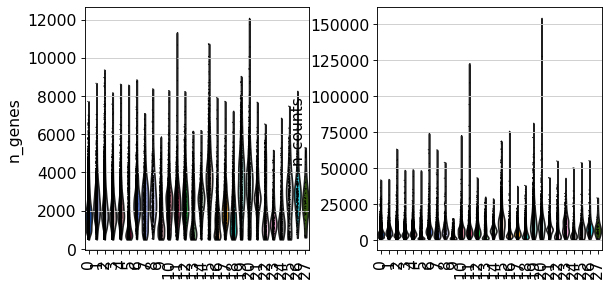

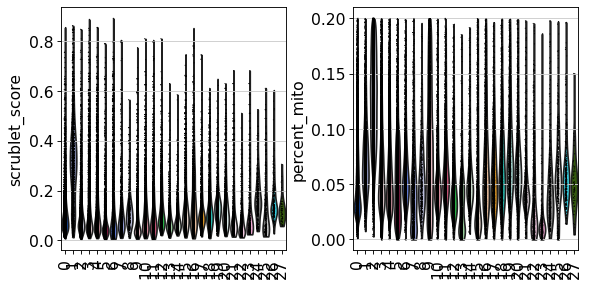

In [20]:
# identify lowQC
sc.pl.violin(adata, ['n_genes', 'n_counts'], groupby='leiden_R', rotation=90)
sc.pl.violin(adata, ['scrublet_score', 'percent_mito'], groupby='leiden_R', rotation=90)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:416: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) / (


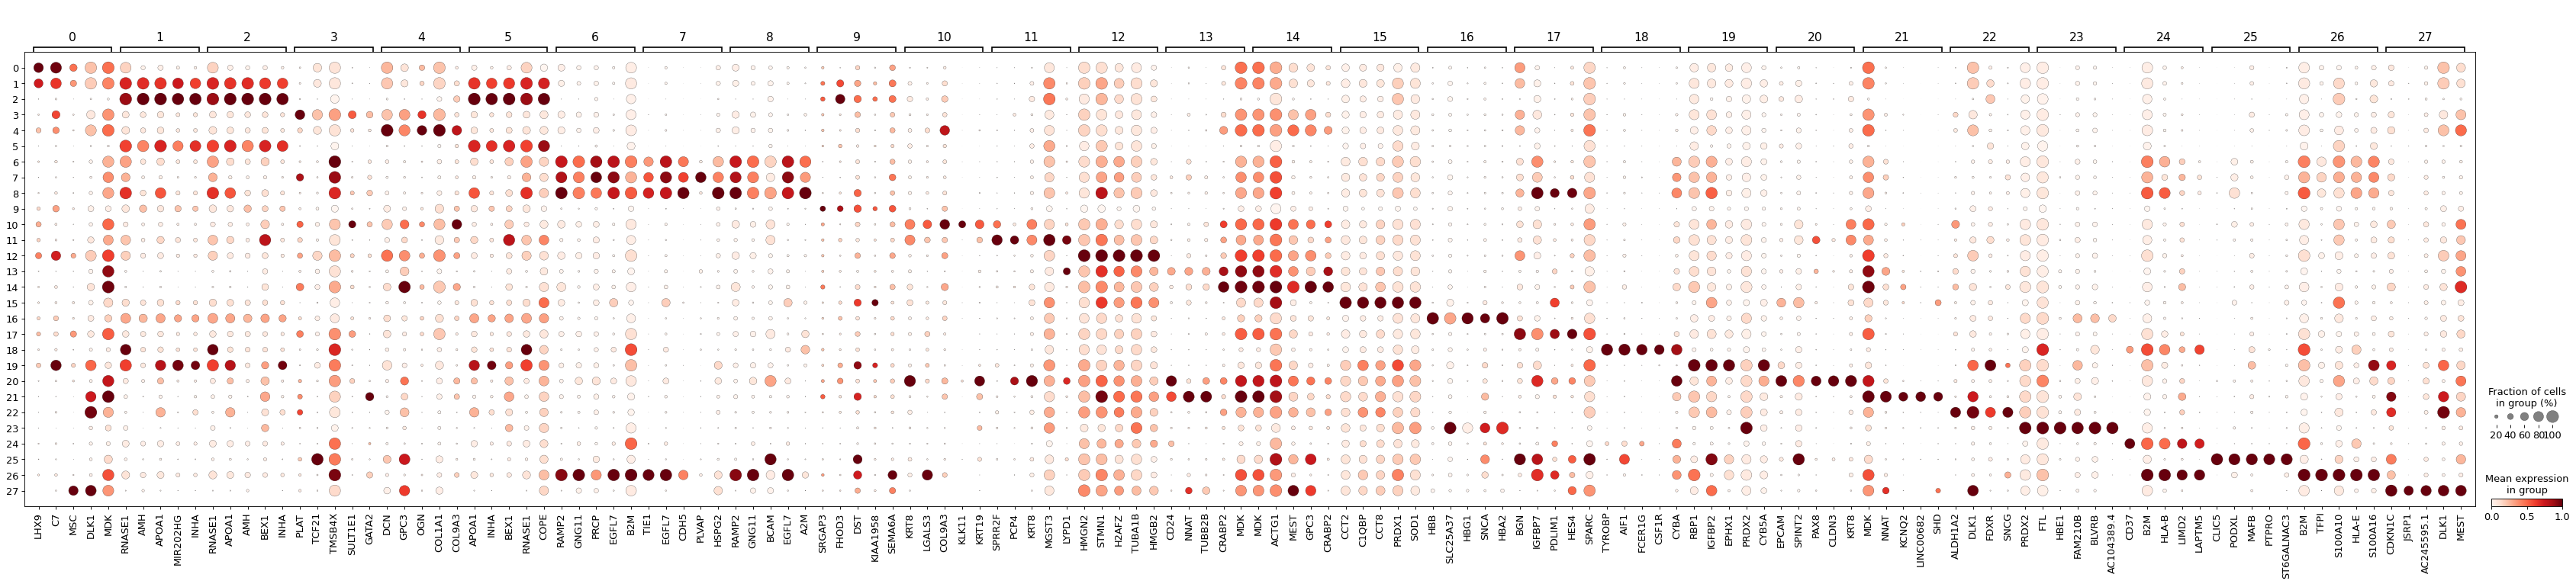

In [21]:
bdata.obs['leiden'] = adata.obs['leiden']
sc.tl.rank_genes_groups(bdata, groupby='leiden', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(bdata, n_genes=5, dendrogram=False, use_raw = False, standard_scale = 'var')

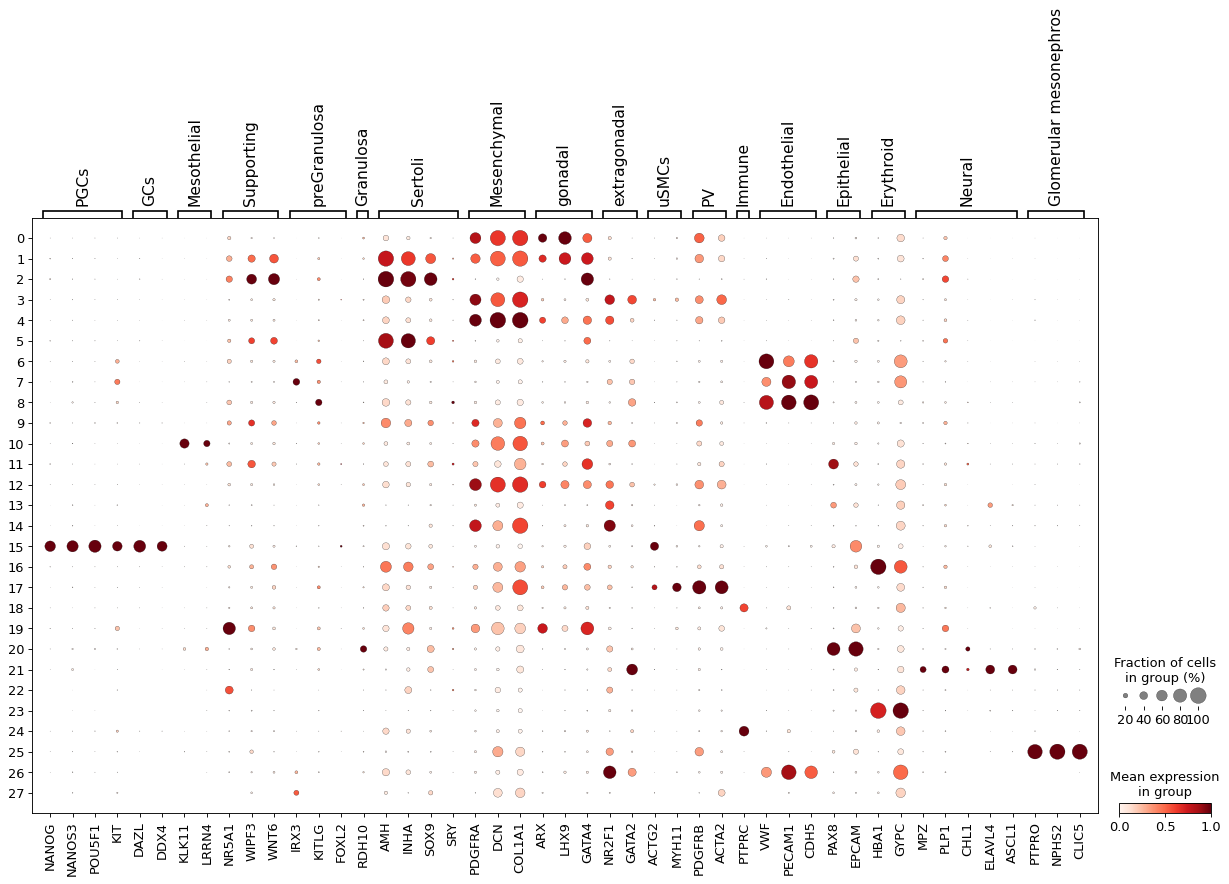

In [22]:
marker_genes = {
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'GCs': {'DAZL', 'DDX4'}, 
    'Mesothelial': {'LRRN4',  'KLK11'},
    'Supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'preGranulosa':{"KITLG", 'FOXL2', 'IRX3'},
    'Granulosa':{'RDH10'},
    'Sertoli': {'SOX9', 'AMH', 'INHA', 'SRY'},
    'Mesenchymal':{'DCN', 'PDGFRA', 'COL1A1'},
    'gonadal':{'GATA4', 'LHX9', 'ARX'},
    'extragonadal':{'GATA2', 'NR2F1'},
    'uSMCs':{'ACTG2', 'MYH11'},
    'PV': {"PDGFRB", 'ACTA2'},
    'Immune': {'PTPRC'},
    'Endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'Epithelial': {"EPCAM", 'PAX8'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Erythroid': {"GYPC", "HBA1"},
    'Neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'},
    'Erythroid': {"GYPC", "HBA1"},
    'Glomerular mesonephros': {"NPHS2", "CLIC5", "PTPRO"}
}
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')

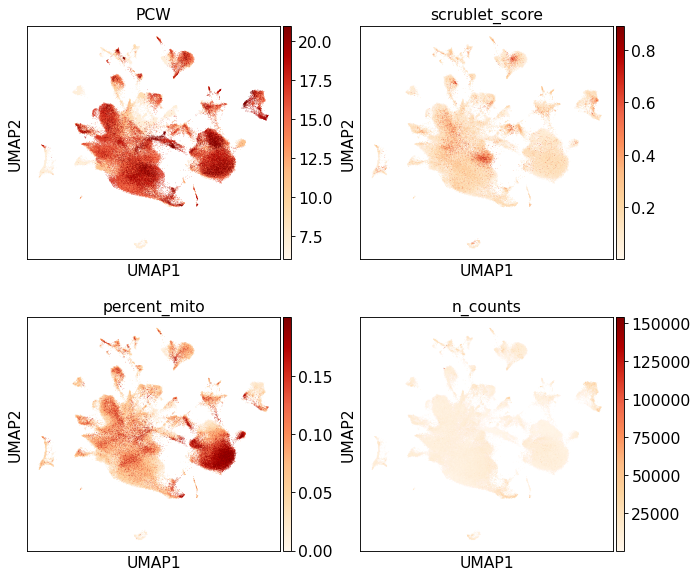

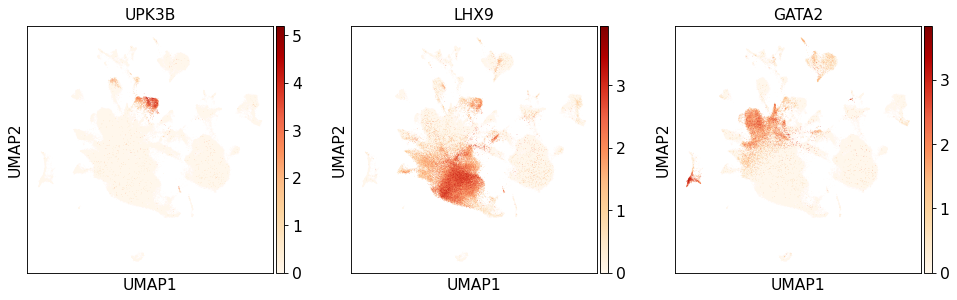

In [23]:
sc.pl.umap(
    adata,
    color=['PCW', 'scrublet_score',  'percent_mito', 'n_counts'], color_map = "OrRd",
    frameon=True, ncols = 2, wspace = 0.2
)

sc.pl.umap(
    adata,
    color=[ 'UPK3B', 'LHX9', 'GATA2',], color_map = "OrRd",
    frameon=True, ncols = 4, wspace = 0.2
)

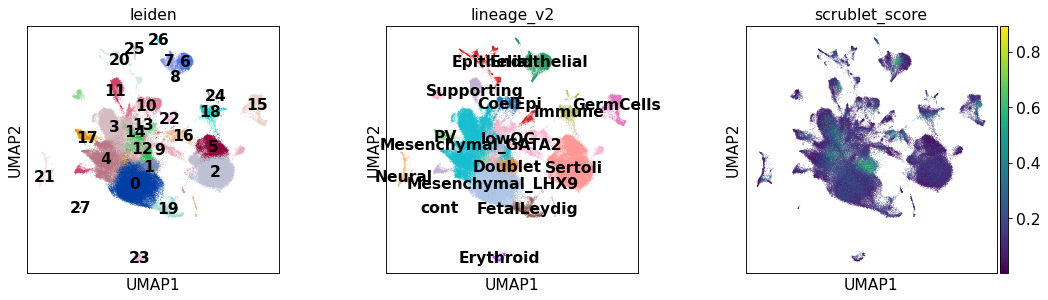

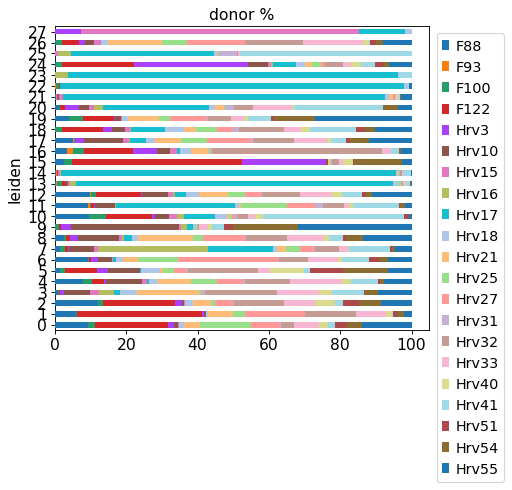

In [24]:
sc.pl.umap(
    adata,
    color=['leiden', 'lineage_v2', 'scrublet_score'], legend_loc='on data',
    frameon=True,  wspace = 0.3
)
Barplot('donor', adata, var='leiden', height=5)

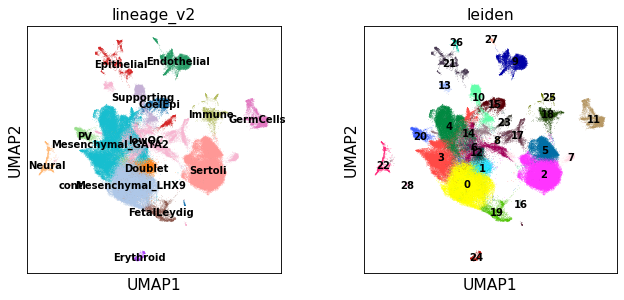

In [31]:
sc.pl.umap(
    adata,
    color=["lineage_v2", 'leiden'], ncols = 2,
    legend_loc='on data', legend_fontsize=9
)

... storing 'lineage' as categorical


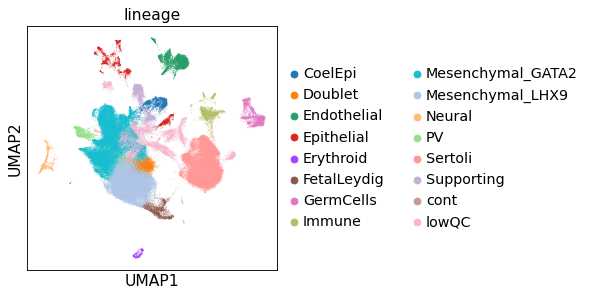

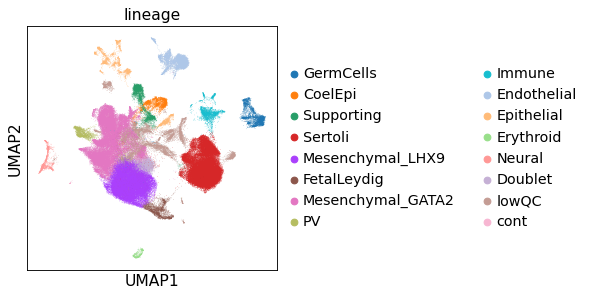

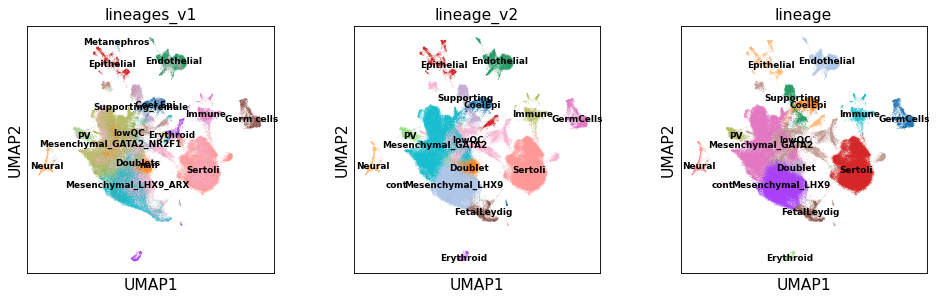

In [32]:
adata.obs['lineage'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['lineage'] == '0', 'lineage'] = 'Mesenchymal_LHX9'
adata.obs.at[adata.obs['lineage'] == '1', 'lineage'] = 'Doublet'
adata.obs.at[adata.obs['lineage'] == '2', 'lineage'] = 'Sertoli'
adata.obs.at[adata.obs['lineage'] == '3', 'lineage'] = 'Mesenchymal_GATA2'
adata.obs.at[adata.obs['lineage'] == '4', 'lineage'] = 'Mesenchymal_GATA2'
adata.obs.at[adata.obs['lineage'] == '5', 'lineage'] = 'Sertoli'
adata.obs.at[adata.obs['lineage'] == '6', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '7', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '8', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '9', 'lineage'] = 'Endothelial'
adata.obs.at[adata.obs['lineage'] == '10', 'lineage'] = 'Supporting'
adata.obs.at[adata.obs['lineage'] == '11', 'lineage'] = 'GermCells'
adata.obs.at[adata.obs['lineage'] == '12', 'lineage'] = 'Mesenchymal_GATA2'
adata.obs.at[adata.obs['lineage'] == '13', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '14', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '15', 'lineage'] = 'CoelEpi'
adata.obs.at[adata.obs['lineage'] == '16', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '17', 'lineage'] = 'lowQC'
adata.obs.at[adata.obs['lineage'] == '18', 'lineage'] = 'Immune'
adata.obs.at[adata.obs['lineage'] == '19', 'lineage'] = 'FetalLeydig'
adata.obs.at[adata.obs['lineage'] == '20', 'lineage'] = 'PV'
adata.obs.at[adata.obs['lineage'] == '21', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '22', 'lineage'] = 'Neural'
adata.obs.at[adata.obs['lineage'] == '23', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '24', 'lineage'] = 'Erythroid'
adata.obs.at[adata.obs['lineage'] == '25', 'lineage'] = 'Immune'
adata.obs.at[adata.obs['lineage'] == '26', 'lineage'] = 'Epithelial'
adata.obs.at[adata.obs['lineage'] == '27', 'lineage'] = 'Endothelial'
adata.obs.at[adata.obs['lineage'] == '28', 'lineage'] = 'cont'
set(adata.obs['lineage'])
sc.pl.umap(adata, color=['lineage'])
adata.obs['lineage'].cat.reorder_categories(['GermCells', 'CoelEpi', 'Supporting', 'Sertoli', 
                                             'Mesenchymal_LHX9', 'FetalLeydig',
                                              'Mesenchymal_GATA2','PV', 
                                              'Immune',  'Endothelial', 
                                              'Epithelial',   
                                                'Erythroid', 'Neural', 'Doublet', 'lowQC', 'cont'], inplace=True)

sc.pl.umap(adata, color=['lineage'])
sc.pl.umap(adata, color=['lineages_v1', 'lineage_v2', 'lineage'], ncols = 3, legend_loc='on data', legend_fontsize=8)

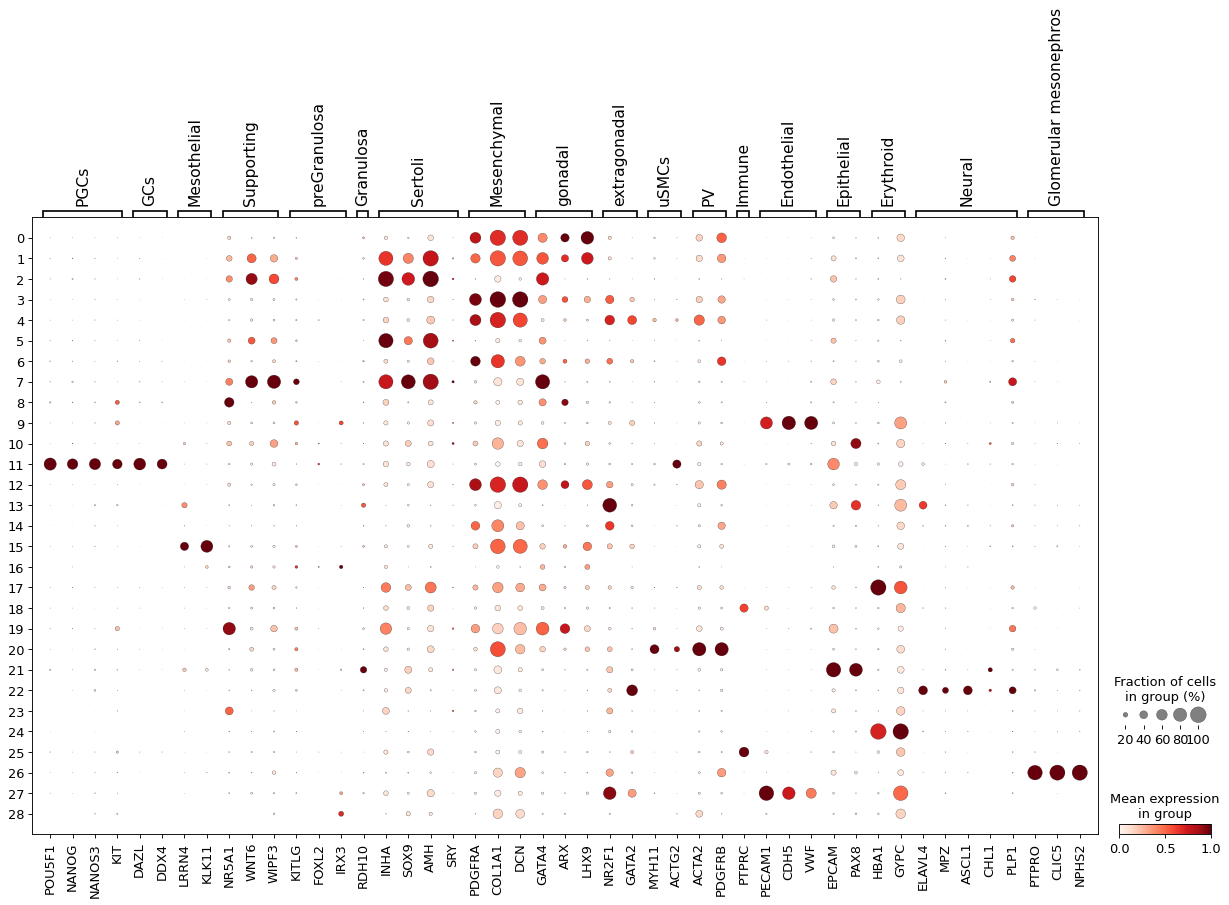

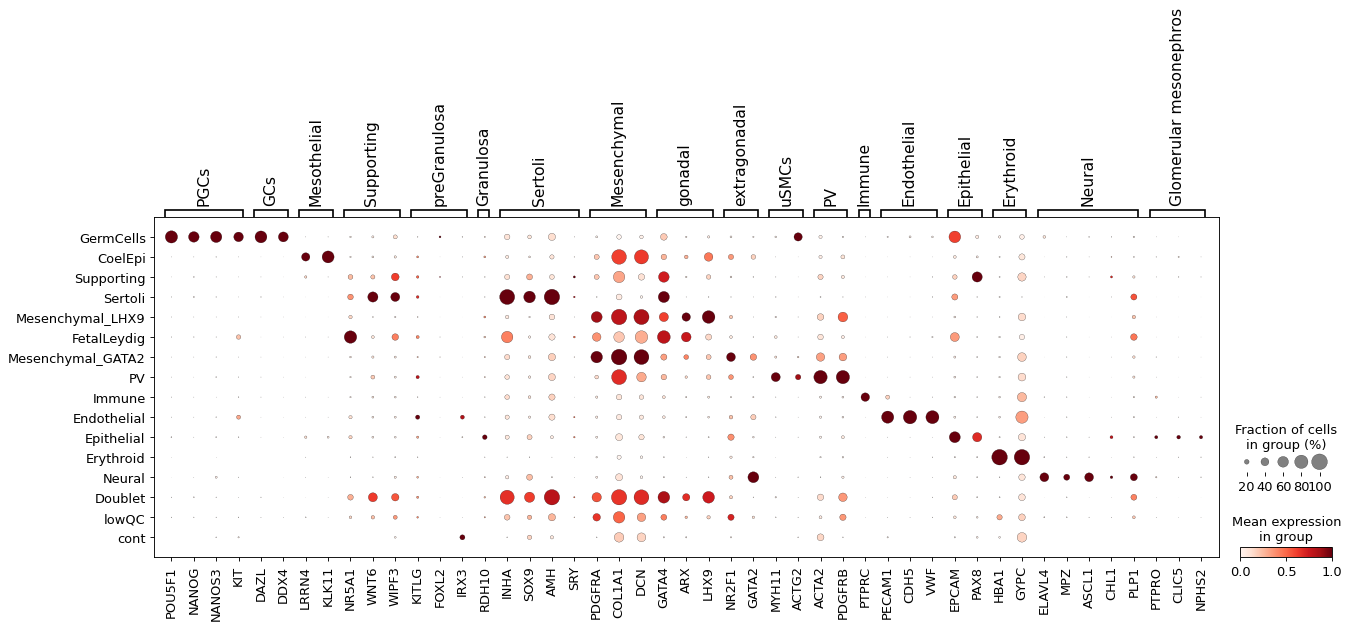

In [33]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', use_raw=False, standard_scale = 'var')
sc.pl.dotplot(adata, marker_genes, groupby='lineage', use_raw=False, standard_scale = 'var')

In [34]:
adata.obs.to_csv(path_to_gonads+'/FCA-gonads_male_annotated.csv')
adata.write(path_to_gonads+'/FCA-gonads_male_annotated.h5ad')

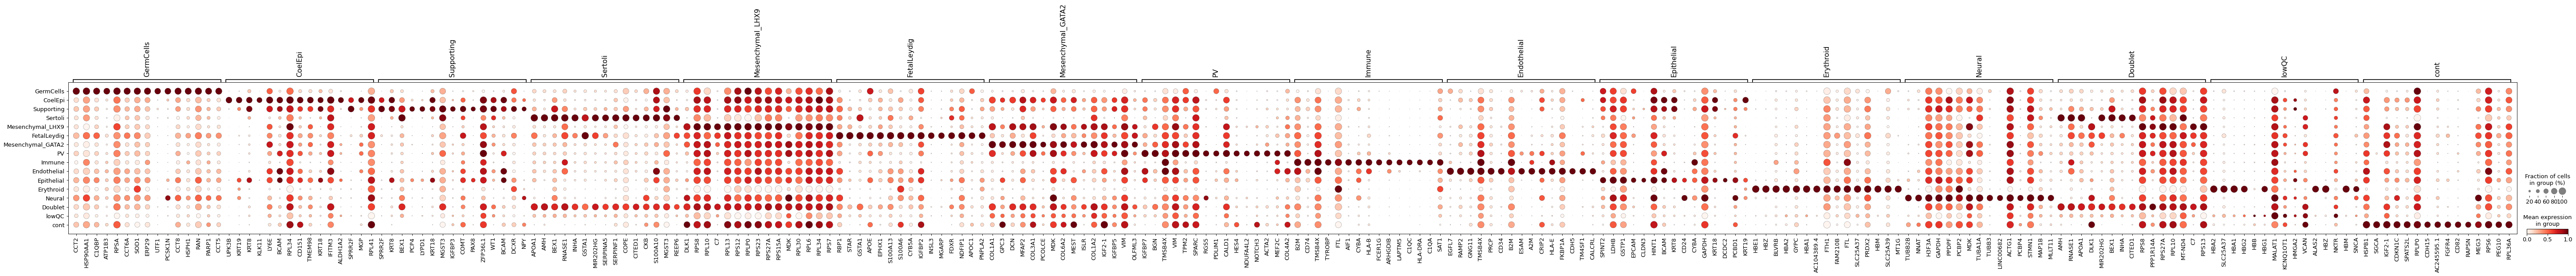

In [35]:
sc.tl.rank_genes_groups(adata, groupby='lineage', use_raw=False) #, method='logreg'
sc.pl.rank_genes_groups_dotplot(adata, n_genes=15, dendrogram=False, use_raw = False, standard_scale = 'var')